In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers




In [2]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1


dropout_val = 0.2
nof_units = 64

corpus = []

In [3]:
def create_model(dropout_val, nof_units):

    
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(dropout_val),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(nof_units),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    return model

In [4]:
num_sentences = 0

with open("../input/twitter-sentiment-clean-dataset/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else:
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [5]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])
    
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size=len(word_index)
sequences = tokenizer.texts_to_sequences(sentences)

padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


split = int(test_portion * training_size)
test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [6]:
embeddings_index = {};
with open('../input/glove6b/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;



In [7]:
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [8]:
model = create_model(dropout_val, nof_units)
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13877100  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,942,253
Trainable params: 65,153
Non-trainable params: 13,877,100
_______________________________________

In [9]:
num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)


Train on 144000 samples, validate on 16000 samples
Epoch 1/50
144000/144000 - 47s - loss: 0.5685 - acc: 0.6981 - val_loss: 0.5454 - val_acc: 0.7142
Epoch 2/50
144000/144000 - 44s - loss: 0.5296 - acc: 0.7289 - val_loss: 0.5101 - val_acc: 0.7419
Epoch 3/50
144000/144000 - 42s - loss: 0.5130 - acc: 0.7419 - val_loss: 0.5044 - val_acc: 0.7481
Epoch 4/50
144000/144000 - 42s - loss: 0.5017 - acc: 0.7503 - val_loss: 0.5134 - val_acc: 0.7421
Epoch 5/50
144000/144000 - 42s - loss: 0.4921 - acc: 0.7563 - val_loss: 0.5025 - val_acc: 0.7518
Epoch 6/50
144000/144000 - 42s - loss: 0.4856 - acc: 0.7603 - val_loss: 0.5003 - val_acc: 0.7509
Epoch 7/50
144000/144000 - 42s - loss: 0.4797 - acc: 0.7646 - val_loss: 0.5040 - val_acc: 0.7533
Epoch 8/50
144000/144000 - 44s - loss: 0.4740 - acc: 0.7682 - val_loss: 0.5010 - val_acc: 0.7546
Epoch 9/50
144000/144000 - 44s - loss: 0.4700 - acc: 0.7710 - val_loss: 0.5008 - val_acc: 0.7534
Epoch 10/50
144000/144000 - 41s - loss: 0.4667 - acc: 0.7728 - val_loss: 0.5

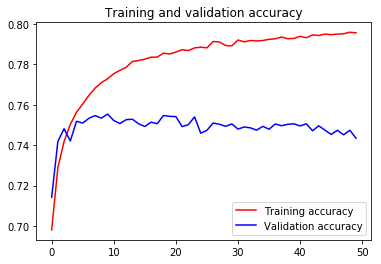

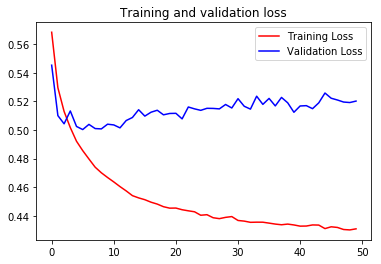

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()